# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to **combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.** This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import pickle

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data overview

In [401]:
# quick look on portfolio dataframe
# offer id needs conversion, will be handled in next section

print('# rows in portfolio dataframe: {}'.format(len(portfolio)))
portfolio

# rows in portfolio dataframe: 10


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [402]:
# quick look on profile dataframe
# user id needs conversion, will be handled in next section

print('# rows in profile dataframe: {}'.format(len(profile)))
profile.head()

# rows in profile dataframe: 17000


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


# of missing gender data: 2175


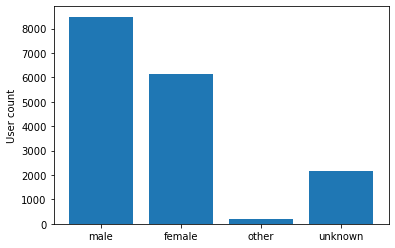

In [9]:
# visualization on gender distribution
# missing values for gender will be handled in next section

gender_non = profile['gender'].isnull().sum()
gender_o = profile['gender'].value_counts()['O']
gender_m = profile['gender'].value_counts()['M']
gender_f = profile['gender'].value_counts()['F']
plt.bar(['male','female','other','unknown'],[gender_m,gender_f,gender_o,gender_non])
plt.ylabel('User count')

print('# of missing gender data: {}'.format(gender_non))

Count the # of missing age data: 0
Count the age group for those above 101 yr old:
118    2175
Name: age, dtype: int64
Count the gender group for those above 101 yr old:
Series([], Name: gender, dtype: int64)
Count the income group for those above 101 yr old:
Series([], Name: income, dtype: int64)
Count the membership history group for those above 101 yr old:
20170901    11
20171002     9
20170907     8
20171126     8
20170928     8
            ..
20160413     1
20160407     1
20160403     1
20170630     1
20160508     1
Name: became_member_on, Length: 950, dtype: int64


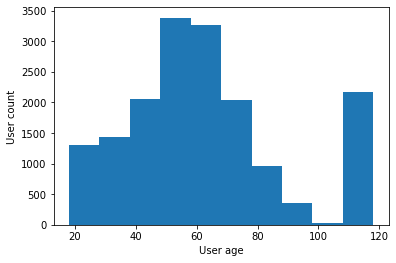

In [8]:
# visualization on age distribution
# a group of suspicious data for age >100, will be labeled as "other" age group in next section
# with a closer look, it's not hard to find that those users are also those with unknown gender and no income.

plt.hist(profile['age'])
plt.xlabel('User age')
plt.ylabel('User count')

print('Count the # of missing age data: {}'.format(profile['age'].isnull().sum()))

print('Count the age group for those above 101 yr old:\n{}'.format(profile[profile['age']>101]['age'].value_counts()))
print('Count the gender group for those above 101 yr old:\n{}'.format(profile[profile['age']>101]['gender'].value_counts()))
print('Count the income group for those above 101 yr old:\n{}'.format(profile[profile['age']>101]['income'].value_counts()))
print('Count the membership history group for those above 101 yr old:\n{}'.format(profile[profile['age']>101]['became_member_on'].value_counts()))


# of missing data on membership history: 0


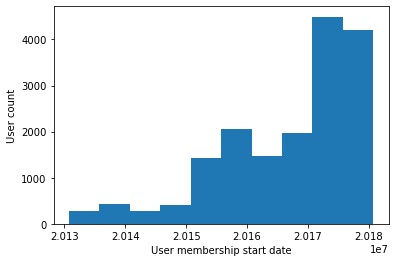

In [10]:
# visualization on membership history distribution
# the membership history spans from 2013 to 2018

plt.hist(profile['became_member_on'])
plt.xlabel('User membership start date')
plt.ylabel('User count')

print('# of missing data on membership history: {}'.format(profile['became_member_on'].isnull().sum()))

# of missing data on income: 2175


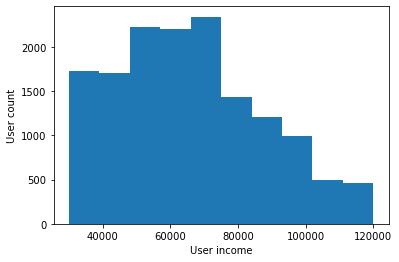

In [12]:
# visualization on income distribution
# the income range is from <40k to 120k

plt.hist(profile['income'])
plt.xlabel('User income')
plt.ylabel('User count')

print('# of missing data on income: {}'.format(profile['income'].isnull().sum()))

In [411]:
# quick look on transcript dataframe
# user id and offer id need conversion in next section

print('# rows in transcript dataframe: {}'.format(len(transcript)))
print('\nEvent type includes: \n{}'.format(transcript['event'].unique()))
transcript.head()

# rows in transcript dataframe: 306534

Event type includes: 
['offer received' 'offer viewed' 'transaction' 'offer completed']


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [406]:
# look at how many users in the dataset have received at least one offer
# turns out that majority of user have, meaning that there is almost no "control" group in the set

user_with_offer = set(transcript[transcript['event']=='offer received']['person'].values)
with_offer_len = len(profile[profile['id'].isin(user_with_offer)])
without_offer_len = len(profile[~profile['id'].isin(user_with_offer)])

print('{} users received at least one offer'.format(with_offer_len))
print('{} users did not receive any offer'.format(without_offer_len))


16994 users received at least one offer
6 users did not reeive any offer


# 2. Data cleaning & preparation

### 2.1 portfolio dataframe

In [413]:
# Add an offer_id column for id name conversion
portfolio['offer_id']=portfolio.index

### 2.2 profile dataframe 

In [421]:
# Create a new column for simple number user id
profile['user_id']=profile.index

In [414]:
# Fill the missing gender in 'gender' column with string 'U', meaning gender unknown/not provided
profile['gender'].fillna('U', inplace=True)

In [416]:
# Creat a new column to define age groups by every 5 years until >80
# First define a function to be applied

def age_group(x):
    '''
    Input:
    x - age value of the user
    Output:
    grp - age group of the user (e.g. <20, 20-25, 25-30, etc.)
    
    Note that there is a group of users age >101 yr, they will be labeled as "unclear" age group
    '''
    
    if x<20:
        grp = '<20'
    elif (x>=20) & (x<25):
        grp = '20-25'
    elif (x>=25) & (x<30):
        grp = '25-30'
    elif (x>=30) & (x<35):
        grp = '30-35'
    elif (x>=35) & (x<40):
        grp = '35-40'        
    elif (x>=40) & (x<45):
        grp = '40-45'
    elif (x>=45) & (x<50):
        grp = '45-50'        
    elif (x>=50) & (x<55):
        grp = '50-55'
    elif (x>=55) & (x<60):
        grp = '55-60'    
    elif (x>=60) & (x<65):
        grp = '60-65'
    elif (x>=65) & (x<70):
        grp = '65-70'
    elif (x>=70) & (x<80):
        grp = '70-80'
    elif (x>=80) & (x<=101):
        grp = '80-101'
    else:
        grp = 'unclear'
    return grp

# Add the age group column
profile['age_group'] = profile['age'].apply(lambda x: age_group(x))

In [417]:
# Creat a new column to define membership history groups by every 1 year 
# First define a function to be applied

def membership_group(x):
    '''
    Input:
    x - date that the user became a member
    Output:
    grp - membership history group of the user (e.g. before_2014, since_2104, etc.)
    '''
    
    if x<20140101:
        grp = 'before_2014'
    elif (x>=20140101) & (x<20150101):
        grp = 'since_2014'
    elif (x>=20150101) & (x<20160101):
        grp = 'since_2015'
    elif (x>=20160101) & (x<20170101):
        grp = 'since_2016'
    elif (x>=20170101) & (x<20180101):
        grp = 'since_2017'
    else:
        grp = 'since_2018'
    return grp

# Add the membership group column
profile['membership_group'] = profile['became_member_on'].apply(lambda x: membership_group(x))

In [419]:
# Creat a new column to define income groups 
# First define a function to be applied

def income_group(x):
    '''
    Input:
    x - user's income
    Output:
    grp - income group of the user (e.g. <40k, 40-60k, etc.)
    '''
    
    if x<40000:
        grp = '<40k'
    elif (x>=40000) & (x<60000):
        grp = '40-60k'
    elif (x>=60000) & (x<80000):
        grp = '60-80k'
    elif (x>=80000) & (x<100000):
        grp = '80-100k'
    elif x>=100000:
        grp = '>100k'
    else:
        grp = 'unknown'
    return grp

# Add the income group column
profile['income_group'] = profile['income'].apply(lambda x: income_group(x))

In [425]:
profile.head()

,gender,age,id,became_member_on,income,membership_group,age_group,income_group,user_id
0,U,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,since_2017,unclear,unknown,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,since_2017,55-60,>100k,1
2,U,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,since_2018,unclear,unknown,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,since_2017,70-80,>100k,3
4,U,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,since_2017,unclear,unknown,4


### 2.3 transcript dataframe 

In [422]:
# Extract the value from the 'event' column into a new column for 'event_value'
# The 'event_value' will be further processed depending on event type

def event_value(x):
    '''
    Input:
    x - value in the 'event' column, x is in a dictionary format
    Output:
    value - the value in the x dictionary, either transaction amount (float) or offer id (str)
    '''
        
    if x.event == 'transaction':
        value = x['value'].get('amount')
    elif x.event == 'offer completed':
        value = x['value'].get('offer_id')
    else:
        value = x['value'].get('offer id')
    return value

# Add the 'event_value' column 
transcript['event_value']=transcript.apply(lambda x: event_value(x), axis=1)

In [424]:
# Clean up the user_id and offer_id in the transcript dataframe

# Create a dictionary for id mapping to clean up user id columns
map_user = dict()
for old_id, new_id in zip(profile['id'],profile['user_id']):
    map_user[old_id]=new_id
    
# Apply the function to clean up user_id    
transcript['person'] = transcript['person'].apply(lambda x: map_user[x])
# Create a new dataframe of transcript containing only offer-relevant records
transcript_offer = transcript[transcript['event']!='transaction'].copy()


# Create a dictionary to map old,long offer id to new,short offer id
map_offer = dict()
# Create a dictionary to map old,long offer id to offer type
map_offer_type = dict()
for old_id, new_id, _type in zip(portfolio['id'],portfolio['offer_id'],portfolio['offer_type']):
    map_offer[old_id]=new_id
    map_offer_type[new_id]=_type

# Apply the function to clean up offer_id and show offer type
transcript_offer['offer_id'] = transcript_offer['event_value'].apply(lambda x: map_offer[x])
transcript_offer['offer_type'] = transcript_offer['offer_id'].apply(lambda x: map_offer_type[x])

In [426]:
transcript_offer.head()

,person,event,value,time,event_value,offer_id,offer_type
0,3,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,3,bogo
1,4,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,discount
2,5,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,9,discount
3,6,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,6,discount
4,7,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,bogo


### 2.4 Define user's responses to offers 

**Methodology**

- **Definition**: 
   - A positive response (1) = should send this offer to this user. 
   - A negative response (0) = no need to send this offer to this user. 
   - An unclear response (NAN) = unclear because the user doesn't view the offer 

- For **informational-type offers (2, 7)**: 
   - The response is considered positive if the user views the offer and then makes a purchase within the offer duration (96hr for offer 2, 72hr for offer 7). 
   - The response is negative if the user views the offer but does not make any purchase within the duration. 
   - If the user does not view the offer, the response is labrled "NAN" (unclear) given that the user is not even aware of the offer.

- For **other offer (0,1,3,4,5,8,9)**: 
   - The response is considered positive if the user views the offer and completes the offer "task". 
   - However, if there is any record of completing the "task" without viewing, then the response is considered negative. This is because the user will probably purchase the product even without the offer in this case. 
   - If the user views the offer but does not complete the task, it is also considered as negative response.
   - If the user doesn't view the offer nor complete the task, it is considered as unclear response.

In [451]:
def define_user_response(offer_id, transcript_offer=transcript_offer, transcript=transcript):
    '''
    Input:
    
    Output:
    user_received - an array of user id for those who received this offer
    
    response_list - a list of response for all users that received this offer
                    1- positive, should send this offer to this user
                    0- negative, no need to send this offer to this user
                    NAN - response is unclear because the user never viewed this offer
                    Note that if a user never viewed the offer but complete task, then response is 0
                    This indicates the user did not need offer motivation to make purchase
                    
    Definition of positive response: see the markdown cell above on methodology
    
    '''
    
    # get the subset of transcript dataframe that is about records of this specific offer
    offer_record = transcript_offer[transcript_offer['offer_id']==offer_id]
    # get an array of the user id for all users that receive this offer   
    user_received = offer_record['person'].unique()
    # create the list for recording every user's response to this offer
    response_list = []
    
    # as explained in above methodology section, use a different criteria for informational type offer (2,7)
    if offer_id in [2,7]:
        
        for user in user_received:
            # create a subset of the offer record that is about this specific user
            record = offer_record[offer_record['person']==user]
            # create a subset of the transaction record that is about this specific user            
            record_trans = transcript[(transcript['person']==user) & (transcript['event']=='transaction')]
            # find the time that this user receives this offer, note that the user can receive it multiple times
            t_received = record[record['event']=='offer received']['time'].values
            # initialize total view/transaction count
            tot_viewed = 0
            tot_trans = 0
            
            # dt is offer duration. offer 2 duration is 96hrs, offer 7 duration is 72hrs
            if offer_id == 2: dt=96
            else: dt=72
            
            # iterate through each offer receival 
            for i in range(len(t_received)):
                t = t_received[i]
                # find out if the user views the offer within offer duration
                viewed = record[(record['event']=='offer viewed')
                                      & (record['time']>t) 
                                      & (record['time']<(t+dt))]
                
                # find out if the user makes any transaction within offer duration
                transaction = record_trans[(record_trans['time']>t) & (record_trans['time']<(t+dt))]
            
                if len(viewed)>0: tot_viewed+=1
                if len(transaction)>0: tot_trans+=1
            
            # if the user never views this offer, record NAN
            if tot_viewed==0:
                response_list.append(np.nan)
            # if the user has viewed the offer but makes no transaction within duration, record 0
            elif (tot_viewed>0) & (tot_trans==0):
                response_list.append(0)
            # if the user has viewed the offer and makes at least one transaction within duration, record 1
            else:
                response_list.append(1)    
                
    # below code is for offer type 0,1,3,4,5,6,8,9 (offer with a completion criteria)   
    else:    
        for person in user_received:
            # create a subset of the offer record that is about this specific user            
            record = offer_record[offer_record['person']==person]
            # count how many times the user has viewed this offer 
            viewed = len(record[record['event']=='offer viewed'])
            # count how many times the user has completed this offer             
            completed = len(record[record['event']=='offer completed'])
                
            # if the user did not view the offer nor complete the task, we don't know if they would like the offer
            # in these cases, user's response is unclear, so label as NAN (invalid outcome)
            if (viewed==0) & (completed==0):
                response_list.append(np.nan)
        
            # if the user at least once completed the task, even if they didn't complete in other times, still good
            # in these cases, user's response is positive, so label is 1 (should send offer)
            elif (viewed>=completed) & (completed>0):
                response_list.append(1)
            
            # if viewed < completed, it indicates the user at least once completed the task without knowing the offer
            # in these cases, no need to "motivate" the user by this offer, so label is 0 (should not send offer)
            else:
                response_list.append(0)
                
    return user_received, response_list


In [452]:
# create a user response dataframe for training machine learning model

# all users that have received at least one offer
all_user_id = transcript_offer['person'].unique()
# all offer ids: 0~9
all_offer_id = portfolio['offer_id'].values
# create an empty dataframe, indexing by all user id
offer_df = pd.DataFrame(index=all_user_id)

for offer_id in all_offer_id:
    
    user_received, response_list = define_user_response(offer_id)
    # create a dataframe for response of each offer type
    offer_column = pd.DataFrame(response_list, index=user_received, columns=[offer_id])
    # merge all dataframe for all offer types, merging by user_id as key
    offer_df = offer_df.merge(offer_column, how='outer', left_index=True, right_index=True)
    
    print('Complete creating records for offer id {}'.format(offer_id))

offer_df.head()

Complete creating records for offer id 1
Complete creating records for offer id 1
Complete creating records for offer id 1
Complete creating records for offer id 1
Complete creating records for offer id 1
Complete creating records for offer id 1
Complete creating records for offer id 1
Complete creating records for offer id 1
Complete creating records for offer id 1
Complete creating records for offer id 1


# 3. Modeling and evaluation

- **Model input(features)**: user gender, age group, membership history group (how long as a member), income group
- **Model output(labels)**: 1 (should send this offer), 0 (no need to send this offer)
- In the previous section, the methodology for determining user's response has been illustrated. In this section, I will split the available data into train and test set, and train several classifiers for predicting offer-user interaction. 
- **The evaluation metric is F1 score for predicting positive responses on each of the offer type**. F1 score is chosen because it reflects a balance between precision and recall and it is suitable in this scenario.
- Classification for each of the offer type will be considered separately (10 different offers), and different classifiers may be chosen as the best classifier for different offer types.

In [473]:
# create a dataframe for all dummy variables, this will be the feature dataframe as model input
X_user = pd.get_dummies(profile[['gender','age_group','membership_group','income_group']])
# set dataframe index as user_id
X_user.index = profile['user_id']

# only consider users who at least receive one offer (only 6 users did not receive any)
user_with_record = set(X_user.index).intersection(offer_df.index)

# update the X_user (X) and offer_df (Y) dataframe to have only users that receive offer 
# & keep user id sequencing the same for X,Y
X_user = X_user.loc[user_with_record]
offer_df = offer_df.loc[user_with_record]

# train, test split, preparing for the multi-output machine learning model training
X_train,X_test,Y_train,Y_test = train_test_split(X_user, offer_df, random_state=1)

In [479]:
# There are many NAN value in the Y_train dataframe as not everybody has a response for every type of offer
# A way is to fill all the NAN using FunkSVD method, interpolating missing response based on known responses
# Note that this is ONLY done for TRAIN set. For TEST set, we will only evaluate actual responses!

# Define a function to perform FunkSVD on the Y_train (user-response matrix)
def FunkSVD(input_mat, latent_features=8, learning_rate=0.01, iters=500):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    input_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    response_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = input_mat.shape[0]
    n_response = input_mat.shape[1]
    num_record = np.count_nonzero(~np.isnan(input_mat))
    
    # initialize the user and response matrices with random values
    user_mat = np.random.rand(n_users,latent_features)
    response_mat = np.random.rand(latent_features,n_response)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for _n in range(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        for x in range(n_users):
            for y in range(n_response):
                if input_mat[x, y] >= 0:
                    error = input_mat[x,y]-np.dot(user_mat[x,:], response_mat[:,y])
                    sse_accum += error**2
                    for i in range(latent_features):
                        user_mat[x,i] += 2*learning_rate*error*response_mat[i,y]
                        response_mat[i,y] += 2*learning_rate*error*user_mat[x,i]
                else:
                    continue
        if _n%50 ==0:
            print('{}, {}'.format(_n, sse_accum))
        
    return user_mat, response_mat 

In [480]:
# convert dataframe to matrix
Y_train_mat = np.array(Y_train)
# compute the U and VT matrix using FunkSVD function above
user_mat, response_mat = FunkSVD(Y_train_mat, latent_features=8, iters=500)
# generate the Y_train matrix with all filled values
Y_train_filled = np.around(np.dot(user_mat,response_mat))
# set predicted response <0 as 0, >1 as 1
Y_train_filled[Y_train_filled<0] = 0
Y_train_filled[Y_train_filled>1] = 1

# convert numpy array to dataframe with user_id as index
Y_train_filled = pd.DataFrame(Y_train_filled, index=X_train.index)
Y_train_filled.head()

Optimization Statistics
Iterations | Mean Squared Error 
0, 10183.41165579133
50, 4095.2857081357747
100, 1074.0257175178435
150, 275.08148386857613
200, 87.1175220110769
250, 32.409247182373576
300, 14.393026610567341
350, 7.492360571035092
400, 4.390081575580023
450, 2.7959876290262344


,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
13363,-0.0,-0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.0
13903,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
11178,0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,1.0,0.0,0.0
3571,-0.0,1.0,-0.0,0.0,-0.0,1.0,1.0,1.0,-0.0,1.0
3672,-0.0,0.0,1.0,0.0,-0.0,1.0,1.0,1.0,1.0,0.0


In [492]:
# train several classifiers and see which one performs the best
clf_rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=400, 
                                                      random_state=2, 
                                                      class_weight='balanced'))

clf_nb = MultiOutputClassifier(MultinomialNB())

clf_sgd = MultiOutputClassifier(SGDClassifier(loss='log'))

# fit to the train set data
clf_rf.fit(X_train,Y_train_filled)
clf_nb.fit(X_train,Y_train_filled)
clf_sgd.fit(X_train,Y_train_filled)

# predict on test set data
Y_pred_rf = clf_rf.predict(X_test)
Y_pred_nb = clf_nb.predict(X_test)
Y_pred_sgd = clf_sgd.predict(X_test)

MultiOutputClassifier(estimator=SGDClassifier(loss='log'))

In [497]:
# evaluate the model using test set on those available responses only
def evaluate_model(Y_pred, Y_test=Y_test):
    '''
    Input:
    Y_pred - predicted user-response array for test set (no NAN, all predicted)
    Y_test - actual user-response dataframe for test set (with NAN for unknown responses)
    clf - trained classifier to be evaluated
    Output:
    f1_dict - a dictionary of the f1 score for all offer type, key:offer type, value:f1 score.
    '''
    
    f1_dict = dict()
    
    for i in range(10):
        # take only the spcific offer type
        y_test = np.array(Y_test.iloc[:,i])
        y_pred = Y_pred[:,i]
    
        # take only those avialable responses in test test
        idx = np.where(y_test>-1)[0]
        y_test = y_test[idx]
        y_pred = y_pred[idx]
        f1_dict[i] = round(f1_score(y_test,y_pred),2)
    return f1_dict

# iterate through all three classifiers for comparison
model = ['Multinomial Naive Bayes','Random Forest','Logistic Regression w/SGD']
predicted = [Y_pred_nb, Y_pred_rf, Y_pred_sgd]

print('**Test set F1 score for each offer type**')
for Y_pred,name in zip(predicted,model):
    f1_dict = evaluate_model(Y_pred)
    print('{}:'.format(name))
    print(f1_dict)

**F1 score for each offer type**
Multinomial Naive Bayes:
{0: 0.7, 1: 0.73, 2: 0.82, 3: 0.59, 4: 0.32, 5: 0.83, 6: 0.84, 7: 0.78, 8: 0.77, 9: 0.64}
Random Forest:
{0: 0.68, 1: 0.68, 2: 0.67, 3: 0.56, 4: 0.48, 5: 0.72, 6: 0.75, 7: 0.63, 8: 0.69, 9: 0.61}
Logistic Regression w/SGD:
{0: 0.67, 1: 0.72, 2: 0.82, 3: 0.6, 4: 0.02, 5: 0.82, 6: 0.83, 7: 0.8, 8: 0.75, 9: 0.4}


In [517]:
# MultinomialNB classfier generally performs the best among the three
# However, RandomForest outperforms MultinomialNB for predicting responses of offer 4
# Therefore, define a function below to use RandomForest to predcit offer 4, and MultinomialNB for all the rest.

def best_classifier(X, clf_rf=clf_rf, clf_nb=clf_nb):
    '''
    Input:
    X -- user-feature dataframe
    clf_rf -- trained RandomForest classifier, used for predicting offer 4
    clf_nb -- trained MultinomialNB classifier, used for predicting rest of the offer types
    Output:
    Y_pred -- an array of predicted user responses for all offer type, row:user, column:offer type
    '''
    
    Y_pred = np.zeros((len(X),len(clf_nb.estimators_)))
    
    for i,clf in enumerate(clf_rf.estimators_):
        if i == 4:
            Y_pred[:,4] = clf.predict(X)
    
    for i,clf in enumerate(clf_nb.estimators_):
        if i != 4:
            Y_pred[:,i] = clf.predict(X)
    
    return Y_pred

Y_pred_best = best_classifier(X_test)
f1_dict = evaluate_model(Y_pred_best)

print('**Test set F1 score for each offer type**')
print(f1_dict)

**Test set F1 score for each offer type**
{0: 0.7, 1: 0.73, 2: 0.82, 3: 0.59, 4: 0.48, 5: 0.83, 6: 0.84, 7: 0.78, 8: 0.77, 9: 0.64}


In [ ]:
# Pickle the two classifiers to use in the web application

pickle.dump(clf_nb, open('models/clf_nb.pkl','wb'))
pickle.dump(clf_rf, open('models/clf_rf.pkl','wb'))

# 4. Conclusion

In this work, I took a modeling approach to achieve the goal of predicting who should receive each type of offers. I frist create a user response dataframe by defining what "positive response" means for each type of offer. Based on the criteria, each user-offer interaction is evaluated as either positive(1), negative(0), or unclear (NAN). 

Then I define my user features as age group, membership history group, gender group, income group and train a few classfiers on my training set data. I also used FunkSVD method to fill in all the missing data for the user-offer interaction matrix. Note that this is just for improving model training and does not affect the integrity and validity of model evaluation, as it is not done for the test set data.

Multinominal NB classifier is found to perform well for most offer types, but Random Forest classifier outperforms it for offer type 4. Therefore, a combined-model classifier is used to make predictions for all offer types. Combining the two classifiers, the **test set F1 score** is:
- 0.8~0.84 for offer 2,5,6
- 0.7~0.8 for offer 0,1,7,8
- 0.64 for offer 9
- 0.59 for offer 3
- 0.48 for offer 4


For any user in our database with features(age, member_since, gender, income) available, we can simply decide which offer to send based on the model prediction (1-send, 0-do not send) 

**A web application is made to allow one to provide customer information and receive offer recommendations**

# 5. Challenges/Improvements

Some of the challenges I had & some potential improvement areas include:

- Define a user's response to an offer: how do we define a positive/negative response? The ML model needs to be trained with a set of known labels (positive/negative response) so this would be an important question to ask. I assume "complete the offer" is the criteria for a positive response and therefore a criteria for sending offer. However, this does not work for informational type of offer as they don't have a clear "completion" criteria. So I assume if the user make a purchase within the information display duration, then it would be a positive response - meaning we should send an offer. This is a rather "generous" definition for "completing" an offer. Maybe one would make a purchase even without seeing the offer. I assume this is okay given that sending informational offer doesn't really cost much.
- Understand the impact of offers by comparison with control group: In the given dataset, almost everybody receives at least one type of offer. So there is essentially no control group data. It is difficult to know what a type of user would behave without any offer. So it is possible that some user groups would purchase the product even without the offer, but our model recommends sending offer to them anyway (because after they see the offer, they do make the purchase).
- "Outlier" data issue: There is a group of "users" that are >101 year's old, have no income info and unknown gender. This group do have quite a lot of transaction and offer-user interaction records. I choose to keep those users in the model training (gender='unknown', age='unclear', income='unknown').
- Better model performance with more user info: different users with the same age, gender, income, and membership history may still react quite differently to the same offer because there are a lot more features of a person beyond these four. To further improve the model performance, we may want to find more features for the user. One thing may be find characteristics of the user's transaction behavior. E.g., average expense on each transaction, number of transactions in each week, etc.